In [354]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics._base import _check_pos_label_consistency
from sklearn.metrics import roc_auc_score
from sklearn.metrics._plot.base import _get_response
from sklearn.utils import assert_all_finite, check_array, check_consistent_length, check_matplotlib_support, column_or_1d
from sklearn.utils.multiclass import type_of_target

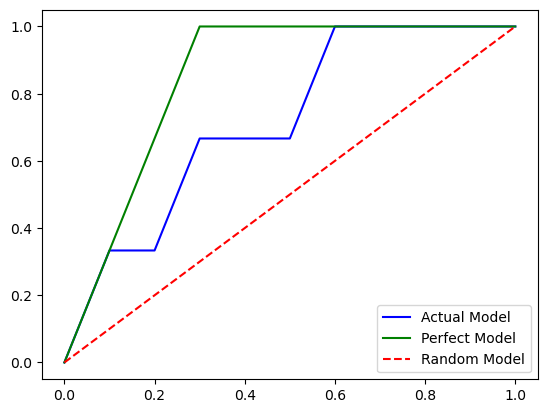

In [153]:
y_true = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
y_score = [0.1, 0.3, 0.0, 0.2, 0.0, 0.8, 0.5, 0.9, 0.4, 1]
y_score = [0.1, 0.3, 0.0, 0.2, 0.0, 0.8, 0.5, 0.5, 0.2, 1]

y_true, y_score = np.asarray(y_true), np.asarray(y_score)

ranking = np.argsort(y_score)[::-1]
ranked = y_true[ranking]

cumulative_gains = np.append(0, np.cumsum(ranked) / np.sum(ranked))
thresholds = np.arange(0, len(ranked)+1) / len(ranked)

plt.plot(
    thresholds, 
    cumulative_gains, 
    color='blue',
    label='Actual Model',
)


positive_rate = np.sum(y_true) / len(y_true)

plt.plot(
    [0, positive_rate, 1], 
    [0, 1, 1],
    color='green',
    label='Perfect Model',
)


plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Model')

plt.legend()

In [364]:
def cap_curve(
    y_true, 
    y_score, 
    sample_weight=None,
):
    """
    Calculates the Cumulative Accuracy Profile (CAP Curve), calculating the
    cumulative gain at each threshold of the percentage of sample examples 
    versus the percentage of class 1 examples.

    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        True targets of binary classification.

    y_score : ndarray of shape (n_samples,)
        Estimated probabilities or output of a model / decision function.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If `None`, all samples are given the same weight.

    Returns
    -------
    cumulative_gains : ndarray of shape (n_samples,)
        Cumulative gain with each threshold (percentage of class 1).

    thresholds : ndarray of shape (n_samples,)
        Increasing thresholds (percentage of examples) on the decision 
        function used to compute cap curve.

    """
    y_type = type_of_target(y_true, input_name="y_true")
    y_true = check_array(y_true, ensure_2d=False, dtype=None)
    y_score = check_array(y_score, ensure_2d=False)
    check_consistent_length(y_true, y_score, sample_weight)

    if y_type != "binary":
        raise NotImplementedError("Only binary blass supported")
    else:
        weights = np.ones(len(y_true)) if sample_weight is None else sample_weight

        ranking = np.argsort(y_score)[::-1]
        ranked = y_true[ranking] * weights

        cumulative_gains = np.append(0, np.cumsum(ranked) / np.sum(ranked))
        thresholds = np.arange(0, len(ranked)+1) / len(ranked)

        return cumulative_gains, thresholds

In [365]:
class CAPCurveDisplay:
    """CAP Curve visualization.

    Parameters
    ----------
    cumulative_gains : ndarray
        Cumulative gain with each threshold (percentage of class 1).

    thresholds : ndarray
        Increasing thresholds (percentage of examples) on the decision 
        function used to compute cap curve.

    positive_rate : ndarray
        Rate of positive class examples to compute the perfect curve.

    gini : float, default=None
        Gini score. If None, the gini score is not shown.

    estimator_name : str, default=None
        Name of estimator. If None, the estimator name is not shown.

    pos_label : str or int, default=None
        The class considered as the positive class when computing the cap curve.
        By default, `estimators.classes_[1]` is considered
        as the positive class.

    Attributes
    ----------
    line_ : matplotlib Artist
        CAP Curve.
    ax_ : matplotlib Axes
        Axes with CAP Curve.
    figure_ : matplotlib Figure
        Figure containing the curve.
    """
    
    def __init__(
        self,
        *,
        cumulative_gains,
        thresholds,
        positive_rate=None,
        gini=None,
        estimator_name=None,
        pos_label=None
    ):
        self.estimator_name = estimator_name
        self.cumulative_gains = cumulative_gains
        self.thresholds = thresholds
        self.positive_rate = positive_rate
        self.gini = gini
        self.pos_label = pos_label

    def plot(
        self, 
        *,
        plot_random=False,
        plot_perfect=False,
        name=None,
        ax=None,
        **kwargs
    ):
        """Plot visualization
        Extra keyword arguments will be passed to matplotlib's ``plot``.

        Parameters
        ----------
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        name : str, default=None
            Name of CAP Curve for labeling. If `None`, use `estimator_name` if
            not `None`, otherwise no labeling is shown.

        plot_random : boolean, default = False
            Flag indicating whether to plot the baseline random curve (True) 
            or not (False).

        plot_perfect : boolean, default = False
            Flag indicating whether to plot the baseline perfect curve (True) 
            or not (False).

        Returns
        -------
        display : :class:`~sklearn.metrics.plot.CAPCurveDisplay`
            Object that stores computed values.
        """
        check_matplotlib_support("CAPCurveDisplay.plot")

        name = self.estimator_name if name is None else name

        line_kwargs = {}
        if self.gini is not None and name is not None:
            line_kwargs["label"] = f"{name} (GINI = {self.gini:0.2f})"
        elif self.gini is not None:
            line_kwargs["label"] = f"Gini = {self.gini:0.2f}"
        elif name is not None:
            line_kwargs["label"] = name

        line_kwargs.update(**kwargs)

        if ax is None:
            fig, ax = plt.subplots()

        if plot_random is True:
            ax.plot([0, 1], [0, 1], linestyle="--", label="Random Model")

        if plot_perfect is True and self.positive_rate is not None:
            ax.plot(
                [0, self.positive_rate, 1], 
                [0, 1, 1],
                label="Perfect Model",
            )
        
        (self.line_,) = ax.plot(self.thresholds, self.cumulative_gains, **line_kwargs)
        info_pos_label = (
            f" (Positive label: {self.pos_label})" if self.pos_label is not None else ""
        )

        xlabel = "% of Observations" + info_pos_label
        ylabel = "% of Positive Observations" + info_pos_label
        ax.set(xlabel=xlabel, ylabel=ylabel)

        if "label" in line_kwargs:
            ax.legend(loc="lower right")

        self.ax_ = ax
        self.figure_ = ax.figure
        return self

    @classmethod
    def from_estimator(
        cls,
        estimator,
        X,
        y,
        *,
        sample_weight=None,
        drop_intermediate=True,
        response_method="auto",
        pos_label=None,
        plot_random=False,
        plot_perfect=False,
        name=None,
        ax=None,
        **kwargs,
    ):
        """Create a CAP Curve display from an estimator.

        Parameters
        ----------
        estimator : estimator instance
            Fitted classifier or a fitted :class:`~sklearn.pipeline.Pipeline`
            in which the last estimator is a classifier.

        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Input values.

        y : array-like of shape (n_samples,)
            Target values.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        drop_intermediate : bool, default=True
            Whether to drop some suboptimal thresholds which would not appear
            on a plotted CAP curve. This is useful in order to create lighter
            CAP curves.

        response_method : {'predict_proba', 'decision_function', 'auto'} \
                default='auto'
            Specifies whether to use :term:`predict_proba` or
            :term:`decision_function` as the target response. If set to 'auto',
            :term:`predict_proba` is tried first and if it does not exist
            :term:`decision_function` is tried next.

        pos_label : str or int, default=None
            The class considered as the positive class when computing the roc auc
            metrics. By default, `estimators.classes_[1]` is considered
            as the positive class.

        plot_random : boolean, default = False
            Flag indicating whether to plot the baseline random curve (True) 
            or not (False).

        plot_perfect : boolean, default = False
            Flag indicating whether to plot the baseline perfect curve (True) 
            or not (False).

        name : str, default=None
            Name of CAP Curve for labeling. If `None`, use the name of the
            estimator.

        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is created.

        **kwargs : dict
            Keyword arguments to be passed to matplotlib's `plot`.

        Returns
        -------
        display : :class:`~sklearn.metrics.plot.CAPCurveDisplay`
            The ROC Curve display.

        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        >>> clf = SVC(random_state=0).fit(X_train, y_train)
        >>> CAPCurveDisplay.from_estimator(clf, X_test, y_test)
        >>> plt.show()
        """
        check_matplotlib_support(f"{cls.__name__}.from_estimator")

        name = estimator.__class__.__name__ if name is None else name

        y_pred, pos_label = _get_response(
            X,
            estimator,
            response_method=response_method,
            pos_label=pos_label,
        )

        return cls.from_predictions(
            y_true=y,
            y_pred=y_pred,
            sample_weight=sample_weight,
            drop_intermediate=drop_intermediate,
            pos_label=pos_label,
            plot_random=plot_random,
            plot_perfect=plot_perfect,
            name=name,
            ax=ax,
            **kwargs,
        )

    @classmethod
    def from_predictions(
        cls,
        y_true,
        y_pred,
        *,
        sample_weight=None,
        drop_intermediate=True,
        pos_label=None,
        plot_random=False,
        plot_perfect=False,
        name=None,
        ax=None,
        **kwargs,
    ):
        """Plot CAP curve given the true and predicted values.

        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            True labels.

        y_pred : array-like of shape (n_samples,)
            Target scores, can either be probability estimates of the positive
            class, confidence values, or non-thresholded measure of decisions
            (as returned by “decision_function” on some classifiers).

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        drop_intermediate : bool, default=True
            Whether to drop some suboptimal thresholds which would not appear
            on a plotted CAP curve. This is useful in order to create lighter
            CAP curves.

        pos_label : str or int, default=None
            The label of the positive class. When `pos_label=None`, if `y_true`
            is in {-1, 1} or {0, 1}, `pos_label` is set to 1, otherwise an
            error will be raised.

        plot_random : boolean, default = False
            Flag indicating whether to plot the baseline random curve (True) 
            or not (False).

        plot_perfect : boolean, default = False
            Flag indicating whether to plot the baseline perfect curve (True) 
            or not (False).

        name : str, default=None
            Name of ROC curve for labeling. If `None`, name will be set to
            `"Classifier"`.

        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        **kwargs : dict
            Additional keywords arguments passed to matplotlib `plot` function.

        Returns
        -------
        display : :class:`~sklearn.metrics.CAPCurveDisplay`
            Object that stores computed values.

        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        >>> clf = SVC(random_state=0).fit(X_train, y_train)
        >>> y_pred = clf.decision_function(X_test)
        >>> CAPCurveDisplay.from_predictions(y_test, y_pred)
        >>> plt.show()
        """
        check_matplotlib_support(f"{cls.__name__}.from_predictions")

        cumulative_gains, thresholds = cap_curve(y_true, y_pred)
        positive_rate = np.sum(y_true) / len(y_true) if plot_perfect is True else None
        gini = (2 * roc_auc_score(y_true, y_score)) - 1

        name = "Classifier" if name is None else name
        pos_label = _check_pos_label_consistency(pos_label, y_true)

        viz = CAPCurveDisplay(
            cumulative_gains=cumulative_gains,
            thresholds=thresholds,
            positive_rate=positive_rate,
            gini=gini,
            estimator_name=name,
            pos_label=pos_label
        )

        return viz.plot(
            ax=ax,
            name=name,
            plot_random=plot_random,
            plot_perfect=plot_perfect,
            **kwargs
        )


In [278]:
y_true = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
y_score = [0.1, 0.3, 0.0, 0.2, 0.0, 0.8, 0.5, 0.9, 0.4, 1]
cap_curve(y_true, y_score)

(array([0.        , 0.33333333, 0.66666667, 0.66666667, 0.66666667,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

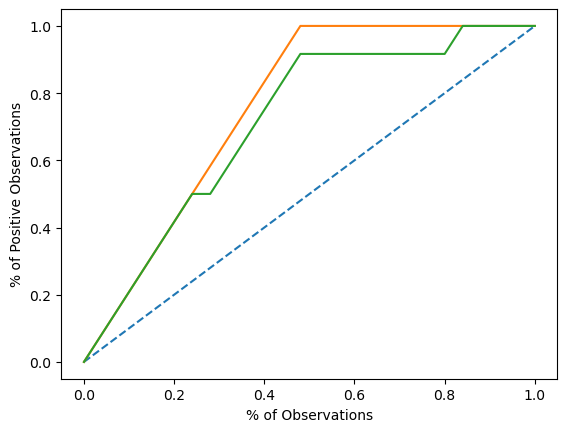

In [366]:
cumulative_gains, thresholds = cap_curve(y_true, y_score)

display = CAPCurveDisplay(cumulative_gains=cumulative_gains, thresholds=thresholds, positive_rate=np.sum(y_true) / len(y_true))
display.plot(plot_perfect=True, plot_random=True)

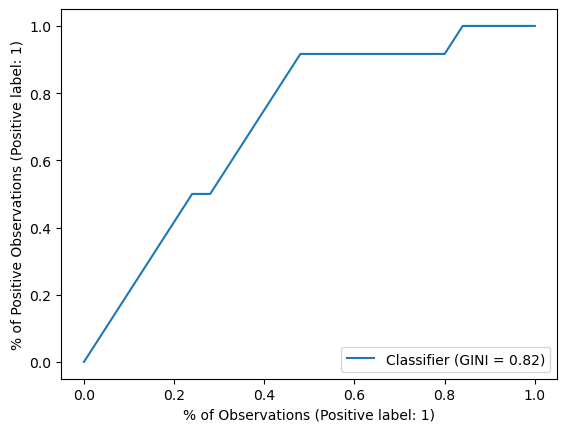

In [367]:
CAPCurveDisplay.from_predictions(y_true=y_true, y_pred=y_score)

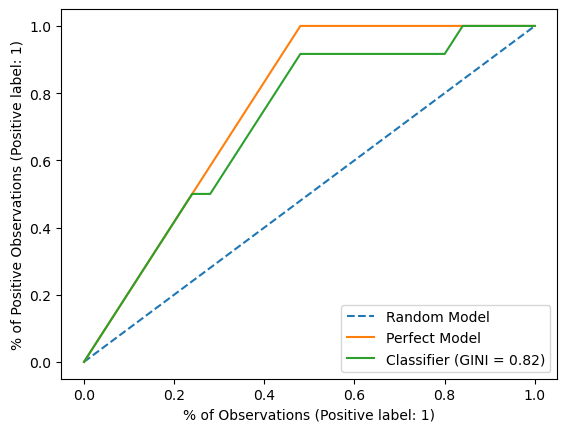

In [368]:
CAPCurveDisplay.from_predictions(y_true=y_true, y_pred=y_score, plot_random=True, plot_perfect=True)

In [369]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_classification(random_state=0)#, n_classes=3, n_features=30, n_informative=20)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [300]:
y

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0])

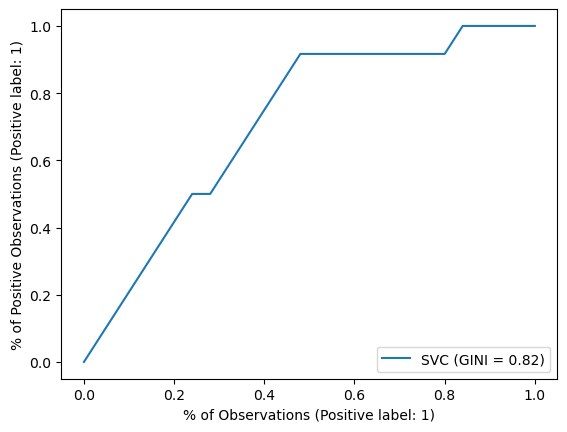

In [370]:
clf = SVC(random_state=0).fit(X_train, y_train)
CAPCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

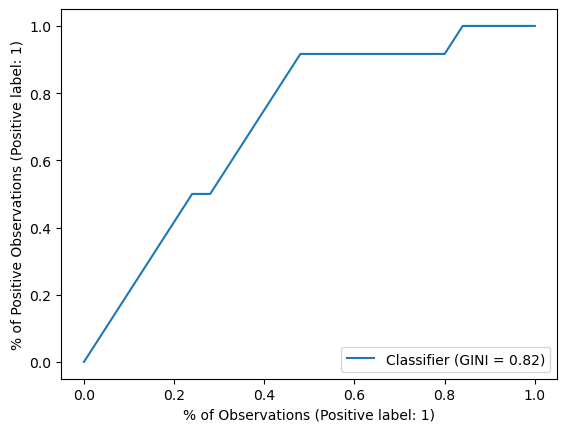

In [371]:
clf = SVC(random_state=0).fit(X_train, y_train)

y_pred = clf.decision_function(X_test)
CAPCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

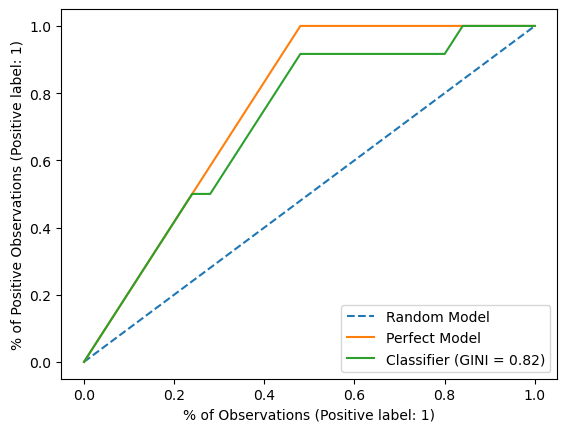

In [372]:
CAPCurveDisplay.from_predictions(y_test, y_pred, plot_perfect=True, plot_random=True)

In [294]:
from typing import List
from itertools import combinations

import numpy as np

def gini(x: List[float]) -> float:
    x = np.array(x, dtype=np.float32)
    n = len(x)
    diffs = sum(abs(i - j) for i, j in combinations(x, r=2))
    return diffs / (2 * n**2 * x.mean())

In [302]:
gini(y_pred)

-4.207617183280257

In [303]:
import numpy as np

#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

-4.207617183280257

In [313]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient


gini(y_pred)

0.36809013253909506

In [311]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred), (2 * roc_auc_score(y_test, y_pred)) - 1)

0.9102564102564102 0.8205128205128205


In [314]:
(2 * roc_auc_score(y_test, y_pred))

1.8205128205128205

In [315]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [346]:
gini(y_test, y_pred)

/var/folders/8m/xzgj38d97fjblgfh2spvsnjw0000gs/T/ipykernel_58420/2338603193.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)


0.2133333333333333

In [344]:
gini_normalized(y_test, y_pred)

/var/folders/8m/xzgj38d97fjblgfh2spvsnjw0000gs/T/ipykernel_58420/2338603193.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)


0.8205128205128204

In [321]:
def gini_score(y_true, y_score):

    y_type = type_of_target(y_true, input_name="y_true")
    y_true = check_array(y_true, ensure_2d=False, dtype=None)
    y_score = check_array(y_score, ensure_2d=False)

    y_all = np.asarray(np.c_[y_true, y_score, np.arrange(len(y_true))], dtype=float)
    y_ordered = y_all[np.lexsort((all[:, 2], -1 * all[:, 1]))]

    if y_type != "binary":
        raise NotImplementedError("Only binary blass supported")
    else:
        a = 6

In [348]:
y_true = list(y_test)
y_score = list(y_pred)

y_type = type_of_target(y_true, input_name="y_true")
y_true = check_array(y_true, ensure_2d=False, dtype=None)
y_score = check_array(y_score, ensure_2d=False)

y_all = np.asarray(np.c_[y_true, y_score, np.arange(len(y_true))], dtype=float)
y_ordered = y_all[np.lexsort((y_all[:, 2], -1 * y_all[:, 1]))]


totalLosses = y_ordered[:, 0].sum()
totalLosses

giniSum = y_ordered[:, 0].cumsum().sum() / totalLosses
giniSum

giniSum -= (len(y_true) + 1) / 2.

giniSum / len(y_true)



0.2133333333333333

In [352]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

gini(y_test, y_pred)

TypeError: gini() takes 1 positional argument but 2 were given

In [381]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.3, 0.8])

CAPCurveDisplay.from_predictions(y_true, y_scores, plot_perfect=True, plot_random=True)

ValueError: Found input variables with inconsistent numbers of samples: [4, 25]

In [387]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.3, 0.8])

cumulative_gain, threasholds = cap_curve(y_true, y_scores)
print(cumulative_gain)
print(threasholds)

[0.  0.5 0.5 1.  1. ]
[0.   0.25 0.5  0.75 1.  ]


In [390]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.3, 0.8])
2 * roc_auc_score(y_true, y_scores) - 1

0.5

In [ ]:
"""
Module with the test for the cap curve functions.
"""
import numpy as np
import pytest
from numpy.testing import assert_array_equal

from ..metrics import cap_curve


def test_cap_curve__success_case():

    y_true = np.array([0, 0, 1, 1])
    y_scores = np.array([0.1, 0.4, 0.3, 0.8])
    cumulative_gain, threasholds, gini = cap_curve(y_true, y_scores)

    assert_array_equal(cumulative_gain, np.array([0, 0.5, 0.5, 1.0, 1.0]))
    assert_array_equal(threasholds, np.array([0, 0.25, 0.5, 0.75, 1.0]))
    assert gini == 0.5


def test_cap_curve__multiclass_exception():

    y_true = np.array([0, 0, 1, 1, 2])
    y_scores = np.array([0.1, 0.4, 0.3, 0.8, 0.04])

    with pytest.raises(Exception) as exc_info:
        _, _, _ = cap_curve(y_true, y_scores)

    assert (
        str(exc_info.value)
        == "Only binary class supported!"
    )


In [ ]:
"""
Module containing the main metrics, curves and displays.
"""
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics._base import _check_pos_label_consistency
from sklearn.metrics._plot.base import _get_response
from sklearn.utils import (
    check_array,
    check_consistent_length,
    check_matplotlib_support,
)
from sklearn.utils.multiclass import type_of_target


def cap_curve(
    y_true,
    y_score,
    sample_weight=None,
):
    """
    Calculates the Cumulative Accuracy Profile (CAP Curve), calculating the
    cumulative gain at each threshold of the percentage of sample examples
    versus the percentage of class 1 examples.

    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        True targets of binary classification.

    y_score : ndarray of shape (n_samples,)
        Estimated probabilities or output of a model / decision function.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If `None`, all samples are given the same weight.

    Returns
    -------
    cumulative_gains : ndarray of shape (n_samples,)
        Cumulative gain with each threshold (percentage of class 1).

    thresholds : ndarray of shape (n_samples,)
        Increasing thresholds (percentage of examples) on the decision
        function used to compute cap curve.

    gini: ndarray of shape (n_samples,)
        The normalized gini coefficient, calculated from the AUC.
    """
    y_type = type_of_target(y_true, input_name="y_true")
    y_true = check_array(y_true, ensure_2d=False, dtype=None)
    y_score = check_array(y_score, ensure_2d=False)
    check_consistent_length(y_true, y_score, sample_weight)

    if y_type != "binary":
        raise NotImplementedError("Only binary class supported!")

    weights = np.ones(len(y_true)) if sample_weight is None else sample_weight

    ranking = np.argsort(y_score)[::-1]
    ranked = y_true[ranking] * weights

    cumulative_gains = np.append(0, np.cumsum(ranked) / np.sum(ranked))
    thresholds = np.arange(0, len(ranked) + 1) / len(ranked)

    # TODO: Test traditional gini calculation
    gini = (2 * roc_auc_score(y_true, y_score, sample_weight=weights)) - 1

    return cumulative_gains, thresholds, gini


class CAPCurveDisplay:
    """CAP Curve visualization.

    Parameters
    ----------
    cumulative_gains : ndarray
        Cumulative gain with each threshold (percentage of class 1).

    thresholds : ndarray
        Increasing thresholds (percentage of examples) on the decision
        function used to compute cap curve.

    positive_rate : ndarray
        Rate of positive class examples to compute the perfect curve.

    gini : float, default=None
        Gini score. If None, the gini score is not shown.

    estimator_name : str, default=None
        Name of estimator. If None, the estimator name is not shown.

    pos_label : str or int, default=None
        The class considered as the positive class when computing the cap curve.
        By default, `estimators.classes_[1]` is considered
        as the positive class.

    Attributes
    ----------
    line_ : matplotlib Artist
        CAP Curve.
    ax_ : matplotlib Axes
        Axes with CAP Curve.
    figure_ : matplotlib Figure
        Figure containing the curve.
    """

    def __init__(
        self,
        *,
        cumulative_gains,
        thresholds,
        positive_rate=None,
        gini=None,
        estimator_name=None,
        pos_label=None,
    ):
        self.estimator_name = estimator_name
        self.cumulative_gains = cumulative_gains
        self.thresholds = thresholds
        self.positive_rate = positive_rate
        self.gini = gini
        self.pos_label = pos_label

    def plot(
        self, *, plot_random=False, plot_perfect=False, name=None, ax=None, **kwargs
    ):
        """Plot visualization
        Extra keyword arguments will be passed to matplotlib's ``plot``.

        Parameters
        ----------
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        name : str, default=None
            Name of CAP Curve for labeling. If `None`, use `estimator_name` if
            not `None`, otherwise no labeling is shown.

        plot_random : boolean, default = False
            Flag indicating whether to plot the baseline random curve (True)
            or not (False).

        plot_perfect : boolean, default = False
            Flag indicating whether to plot the baseline perfect curve (True)
            or not (False).

        Returns
        -------
        display : :class:`~sklearn.metrics.plot.CAPCurveDisplay`
            Object that stores computed values.
        """
        check_matplotlib_support("CAPCurveDisplay.plot")

        name = self.estimator_name if name is None else name

        line_kwargs = {}
        if self.gini is not None and name is not None:
            line_kwargs["label"] = f"{name} (GINI = {self.gini:0.2f})"
        elif self.gini is not None:
            line_kwargs["label"] = f"Gini = {self.gini:0.2f}"
        elif name is not None:
            line_kwargs["label"] = name

        line_kwargs.update(**kwargs)

        if ax is None:
            fig, ax = plt.subplots()

        if plot_random is True:
            ax.plot([0, 1], [0, 1], linestyle="--", label="Random Model")

        if plot_perfect is True and self.positive_rate is not None:
            ax.plot(
                [0, self.positive_rate, 1],
                [0, 1, 1],
                label="Perfect Model",
            )

        (self.line_,) = ax.plot(self.thresholds, self.cumulative_gains, **line_kwargs)
        info_pos_label = (
            f" (Positive label: {self.pos_label})" if self.pos_label is not None else ""
        )

        xlabel = "% of Observations" + info_pos_label
        ylabel = "% of Positive Observations" + info_pos_label
        ax.set(xlabel=xlabel, ylabel=ylabel)

        if "label" in line_kwargs:
            ax.legend(loc="lower right")

        self.ax_ = ax
        self.figure_ = ax.figure
        return self

    @classmethod
    def from_estimator(
        cls,
        estimator,
        X,
        y,
        *,
        sample_weight=None,
        response_method="auto",
        pos_label=None,
        plot_random=False,
        plot_perfect=False,
        name=None,
        ax=None,
        **kwargs,
    ):
        """Create a CAP Curve display from an estimator.

        Parameters
        ----------
        estimator : estimator instance
            Fitted classifier or a fitted :class:`~sklearn.pipeline.Pipeline`
            in which the last estimator is a classifier.

        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Input values.

        y : array-like of shape (n_samples,)
            Target values.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        response_method : {'predict_proba', 'decision_function', 'auto'} \
                default='auto'
            Specifies whether to use :term:`predict_proba` or
            :term:`decision_function` as the target response. If set to 'auto',
            :term:`predict_proba` is tried first and if it does not exist
            :term:`decision_function` is tried next.

        pos_label : str or int, default=None
            The class considered as the positive class when computing the roc auc
            metrics. By default, `estimators.classes_[1]` is considered
            as the positive class.

        plot_random : boolean, default = False
            Flag indicating whether to plot the baseline random curve (True)
            or not (False).

        plot_perfect : boolean, default = False
            Flag indicating whether to plot the baseline perfect curve (True)
            or not (False).

        name : str, default=None
            Name of CAP Curve for labeling. If `None`, use the name of the
            estimator.

        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is created.

        **kwargs : dict
            Keyword arguments to be passed to matplotlib's `plot`.

        Returns
        -------
        display : :class:`~sklearn.metrics.plot.CAPCurveDisplay`
            The ROC Curve display.

        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        >>> clf = SVC(random_state=0).fit(X_train, y_train)
        >>> CAPCurveDisplay.from_estimator(clf, X_test, y_test)
        >>> plt.show()
        """
        check_matplotlib_support(f"{cls.__name__}.from_estimator")

        name = estimator.__class__.__name__ if name is None else name

        y_score, pos_label = _get_response(
            X,
            estimator,
            response_method=response_method,
            pos_label=pos_label,
        )

        return cls.from_predictions(
            y_true=y,
            y_score=y_score,
            sample_weight=sample_weight,
            pos_label=pos_label,
            plot_random=plot_random,
            plot_perfect=plot_perfect,
            name=name,
            ax=ax,
            **kwargs,
        )

    @classmethod
    def from_predictions(
        cls,
        y_true,
        y_score,
        *,
        sample_weight=None,
        pos_label=None,
        plot_random=False,
        plot_perfect=False,
        name=None,
        ax=None,
        **kwargs,
    ):
        """Plot CAP curve given the true and predicted values.

        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            True labels.

        y_pred : array-like of shape (n_samples,)
            Target scores, can either be probability estimates of the positive
            class, confidence values, or non-thresholded measure of decisions
            (as returned by “decision_function” on some classifiers).

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        pos_label : str or int, default=None
            The label of the positive class. When `pos_label=None`, if `y_true`
            is in {-1, 1} or {0, 1}, `pos_label` is set to 1, otherwise an
            error will be raised.

        plot_random : boolean, default = False
            Flag indicating whether to plot the baseline random curve (True)
            or not (False).

        plot_perfect : boolean, default = False
            Flag indicating whether to plot the baseline perfect curve (True)
            or not (False).

        name : str, default=None
            Name of ROC curve for labeling. If `None`, name will be set to
            `"Classifier"`.

        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        **kwargs : dict
            Additional keywords arguments passed to matplotlib `plot` function.

        Returns
        -------
        display : :class:`~sklearn.metrics.CAPCurveDisplay`
            Object that stores computed values.

        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        >>> clf = SVC(random_state=0).fit(X_train, y_train)
        >>> y_pred = clf.decision_function(X_test)
        >>> CAPCurveDisplay.from_predictions(y_test, y_pred)
        >>> plt.show()
        """
        check_matplotlib_support(f"{cls.__name__}.from_predictions")

        cumulative_gains, thresholds, gini = cap_curve(y_true, y_score, sample_weight)
        positive_rate = np.sum(y_true) / len(y_true) if plot_perfect is True else None

        name = "Classifier" if name is None else name
        pos_label = _check_pos_label_consistency(pos_label, y_true)

        viz = CAPCurveDisplay(
            cumulative_gains=cumulative_gains,
            thresholds=thresholds,
            positive_rate=positive_rate,
            gini=gini,
            estimator_name=name,
            pos_label=pos_label,
        )

        return viz.plot(
            ax=ax,
            name=name,
            plot_random=plot_random,
            plot_perfect=plot_perfect,
            **kwargs,
        )
